IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

<font size="+1" color="RED"><b>[Q]</b></font> <font size="+1"><b>Indiquer dans la boîte ci-dessous vos noms et prénoms :</b></font>

*Double-cliquer ici et insérer les noms et prénoms de votre binôme*

Paul JARSKI

Neil BENAHMED

Ce projet peut être fait en binôme (d'un même groupe). Le nom de chaque membre du binôme doit être indiqué, et un seul rendu sur un des deux comptes Moodle doit être fait.

Les groupes de plus de 2 personnes ne sont pas autorisés.

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>projet-1</tt> et rajouter à la suite de <tt>projet-1</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au notebook** : *projet-1-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme

**Le compte-rendu doit être rendu sur la page Moodle.**

# Projet 1 - février-mars 2023


<font size="+1" color="RED"><b>Date de rendu : jeudi 22 mars, 18h au plus tard</b></font>
<br />


Vous devez compléter ce notebook en rajoutant vos expérimentations avec vos algorithmes d'apprentissage sur les 2 datasets fournis dans le répertoire data-projet:
- les données data-2D.pkl : données en 2 dimensions, 2 labels
- les données data-5D.pkl : données en 5 dimensions, 2 labels

## Travail à faire

Pour chaque ensemble de données:
- les 3 algorithmes d'apprentissage knn, perceptron et perceptron biais doivent être expérimentés et comparés (ATTENTION: on ne veut que des algorithmes que vous avez implémentés vous-même dans cette UE).
- des résultats d'expérimentations doivent fournir une comparaison des taux de bonne classification apprentissage / test avec validation croisée en 10.
- des courbes (coût, poids, variation d'accuracy,...) doivent être fournies pour étudier les modèles construits.

Vos **expérimentations doivent être expliquées**... (utilisez des boîtes Markdown pour saisir vos explications):
- une argumentation du type *"pourquoi vous avez fait cette expérimentation"* doit être fournie;
- une analyse succincte du résultat fourni doit être aussi donnée.



Par exemple (indicatif): choix de $k$ pour le knn:
- argumentation : pour décider quelle peut être la valeur de $k$ optimale, on décide de tester plusieurs valeurs différentes et de comparer les taux de bonne classification sur la base de test obtenus.
- analyse du résultat: on remarque que la valeur $k$ suivante fournie le meilleur résultat.
- étude du temps d'exécution.


## Travail à rendre
Ce qui doit être rendu : un fichier archive (`.tar`, `.tgz`, ou `.zip` uniquement) contenant uniquement ce notebook, dans lequel vous avez reporté toutes les fonctions que vous utilisez : ce notebook doit pouvoir être exécuté sans autre apport (pensez à vous en assurer avant de le rendre). Les fichiers de données ne doivent pas être inclus dans votre archive !



## Lecture des pickles



In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from sklearn.utils import shuffle


%matplotlib inline

# Importation de la librairie pickle
import pickle as pkl

# lecture des donnéees en dimension 2 dans un dataframe pandas
data2D = pkl.load(open('data-projet/data-2D.pkl', 'rb')) 
X2D = np.array(data2D[['x1', 'x2']], dtype=float) # conversion de type pour une meilleure compatibilité
Y2D = np.array(data2D['label'], dtype=float)

# pour les données en dimension 5, la méthode est la même, modifier seulement les noms des colonnes
data5D = pkl.load(open('data-projet/data-5D.pkl','rb'))
X5D = np.array(data5D[['x1','x2','x3','x4','x5']], dtype=float)
Y5D = np.array(data5D['label'], dtype=float)


In [2]:
data2D['label'].unique


<bound method Series.unique of 0      -1
1      -1
2      -1
3      -1
4      -1
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 2000, dtype: int64>

In [3]:
data2D[0:5]

,x1,x2,label
0,0.830557,-2.250314,-1
1,0.627488,-2.533405,-1
2,-1.279837,-1.630564,-1
3,2.002088,-3.415239,-1
4,3.141847,-0.376081,-1


In [4]:
# a supprimer plus tard
#sns.pairplot(data2D, hue='label')

In [5]:
X2D[0:5]

array([[ 0.83055692, -2.25031368],
       [ 0.62748844, -2.53340502],
       [-1.27983681, -1.63056446],
       [ 2.00208794, -3.41523902],
       [ 3.14184699, -0.37608089]])

In [6]:
np.unique(Y5D)

array([-1.,  1.])

In [7]:
Y2D

array([-1., -1., -1., ...,  1.,  1.,  1.])

## Code de nos algorithmes implémentés :

### Classifieurs

In [8]:
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
        
    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        cpt=0
        n = len(desc_set)
        predict_label = []
        for i in range(n):
            predict_label.append(self.predict(desc_set[i]))
        accuracy= np.mean(np.array(predict_label)==np.array(label_set))
        return accuracy  

In [9]:
class ClassifierKNN(Classifier):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """
    def __init__(self, input_dimension, k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - k (int) : nombre de voisins à considérer
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.k = k
        
        
    def score(self,x):
        """ rend la proportion de +1 parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        #dist = [np.sqrt((x[0]-self.desc_set[i][0])**2+(x[1]-self.desc_set[i][1])**2) for i in range(len(self.desc_set))]
        distances = [distance.euclidean(desc, x) for desc in self.desc_set]
        top_k_indices = np.argsort(distances)[:self.k]
        p = sum(1 for i in top_k_indices if self.label_set[i] == 1) / self.k
        return 2 * (p - 0.5)

    
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
            x: une description : un ndarray
        """
        if self.score(x) > 0:
            return +1
        else:
            return -1 #on ne considère pas le cas score==0

        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.desc_set = desc_set
        self.label_set = label_set

In [10]:
class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True ):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        if init:
            self.w = np.zeros(self.input_dimension)
        else:
            self.w = np.asarray([(2*(np.random.uniform(0,1)) - 1)*0.0001 for i in range(input_dimension)])
        self.allw =[self.w.copy()]
        
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        desc_set2, label_set2 = shuffle(desc_set, label_set)
        for xi,yi in zip(desc_set2, label_set2):
            if self.predict(xi) != yi:
                self.w = self.w + self.learning_rate*yi*xi
                self.allw.append(self.w.copy())
                

    def train(self, desc_set, label_set, nb_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - nb_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """
        liste_difference=[]
        for i in range(nb_max):
            w_avant = self.w.copy()
            self.train_step(desc_set,label_set)
            difference = np.abs(self.w - w_avant)
            change = np.linalg.norm(difference)
            liste_difference.append(change)
            if change <= seuil:
                break
        return liste_difference
        
        
    def get_allw(self):
        return self.allw
            
        
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.vdot(x,self.w)
    
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        return 1 if self.score(x) > 0 else -1

In [11]:
class ClassifierPerceptronBiais(ClassifierPerceptron):
    """ Perceptron de Rosenblatt avec biais
        Variante du perceptron de base
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        super().__init__(input_dimension, learning_rate, init)
        
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """   
        n =  len(desc_set)       
        indexes =[i for i in range(n)]
        np.random.shuffle(indexes)
        desc_set2 = desc_set[indexes]
        label_set2 = label_set[indexes]
        for xi,yi in zip(desc_set2, label_set2):
            if self.score(xi)*yi <= 1:
                self.w = self.w + self.learning_rate*(yi - self.score(xi))*xi
                self.allw.append(self.w.copy())     

### Train-test split et validation croisée

In [12]:
def genere_train_test(desc_set, label_set, n_pos, n_neg):
    """ permet de générer une base d'apprentissage et une base de test
        desc_set: ndarray avec des descriptions
        label_set: ndarray avec les labels correspondants
        n_pos: nombre d'exemples de label +1 à mettre dans la base d'apprentissage
        n_neg: nombre d'exemples de label -1 à mettre dans la base d'apprentissage
        Hypothèses: 
           - desc_set et label_set ont le même nombre de lignes)
           - n_pos et n_neg, ainsi que leur somme, sont inférieurs à n (le nombre d'exemples dans desc_set)
    """    
    label_set_pos = label_set[label_set == +1]
    label_set_neg = label_set[label_set == -1]
    desc_set_pos = desc_set[label_set == + 1]
    desc_set_neg = desc_set[label_set == -1]
    
    ind_positif = random.sample([i for i in range(0,label_set_pos.shape[0])],len(label_set_pos))
    ind_negatif = random.sample([i for i in range(0,label_set_neg.shape[0])],len(label_set_neg))
    
    desc_set_pos = desc_set_pos[ind_positif]
    desc_set_neg = desc_set_neg[ind_negatif]
    
    label_set_pos = label_set_pos[ind_positif]
    label_set_neg = label_set_neg[ind_negatif]
    
    train_desc = np.concatenate((desc_set_pos[:n_pos],  desc_set_neg[:n_neg]),axis=0)
    train_label = np.concatenate((label_set_pos[:n_pos], label_set_neg[:n_neg]),axis=0) 
    test_desc =  np.concatenate((desc_set_pos[n_pos:], desc_set_neg[n_neg:]),axis=0)
    test_label = np.concatenate((label_set_pos[n_pos:], label_set_neg[n_neg:]),axis=0)

    return (train_desc, train_label), (test_desc, test_label)

In [13]:
def crossval_strat(X, Y, n_iterations, iteration):
    index_pos = [ i for i in range(len(Y)) if Y[i]==1]
    index_neg = [ i for i in range(len(Y)) if Y[i]== -1]

    index_pos_test = index_pos[iteration*(len(index_pos) // n_iterations ): (iteration+1)*(len(index_pos) // n_iterations) ]
    index_neg_test = index_neg[iteration*(len(index_neg) // n_iterations ): (iteration+1)*(len(index_neg) // n_iterations) ]
    
    Xtest = np.concatenate(( X[index_neg_test] , X[index_pos_test]  ))
    Ytest =  np.concatenate(( Y[index_neg_test] , Y[index_pos_test] ))
    
    index_app = [i for i in range(len(Y)) if ((i not in index_pos_test) and (i not in index_neg_test) )]

    Xapp =  X[index_app]
    Yapp =  Y[index_app]
    return Xapp, Yapp, Xtest, Ytest

In [14]:
def analyse_perfs(L):
    """ L : liste de nombres réels non vide
        rend le tuple (moyenne, écart-type)
    """
    return (np.mean(L),np.std(L))

In [15]:
def validation_croisee_knn(niter, X, Y, dims, k):   
    index = np.random.permutation(X.shape[0]) # mélange des index
    X_melange = X[index]
    Y_melange = Y[index]
    perf = []
    for i in range(niter):
        Xapp,Yapp,Xtest,Ytest = crossval_strat(X_melange, Y_melange, niter, i)
        knn = ClassifierKNN(dims,k)
        knn.train(Xapp, Yapp)
        perf.append(knn.accuracy(Xtest, Ytest))
    return perf, analyse_perfs(perf)

## CLASSIFIEUR KNN

### Données 2D

#### Estimation d'une bonne valeur de k
On teste ci-dessous de différentes valeurs de k.  À partir de k=5 le modèle est assez fiable.  À partir de k=23 on n'a pas du tout intérêt à augmenter la valeur de k, car la fiabilité du modèle diminue.

In [16]:
#Parametres...à modifier
pourcentage_train = 0.7
k_max = 30  #max value de k à tester

In [17]:
#Code de génération du test-train split...pas à modifier
npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, y_train), (X_test, y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


In [18]:
accuracies1 = []

for k in range(1,k_max+1):
    knn = ClassifierKNN(2,k)
    knn.train(X_train, y_train)
    acc = knn.accuracy(X_test, y_test)
    accuracies1.append(acc)
    

Text(0, 0.5, 'Accuracy')

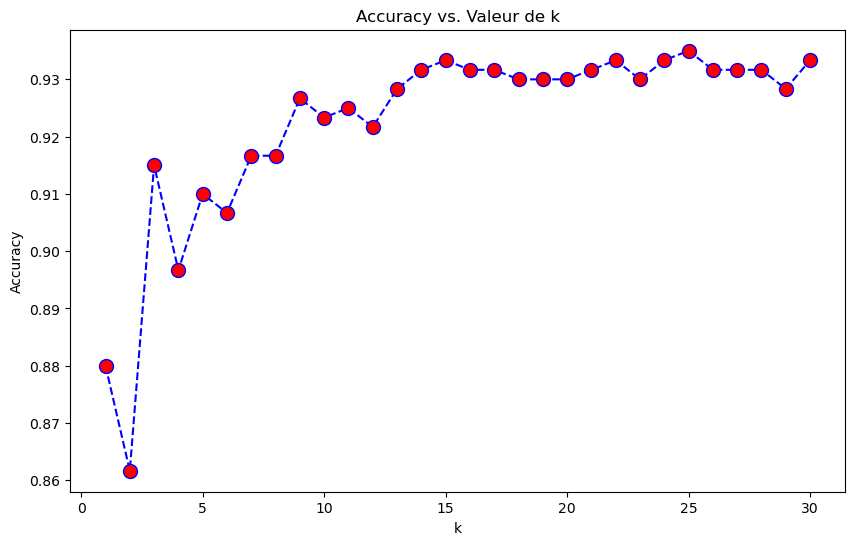

In [19]:
plt.figure(figsize=(10,6))
plt.plot(range(1,k_max+1),accuracies1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Valeur de k')
plt.xlabel('k')
plt.ylabel('Accuracy')

#### Cross-validation
de k = 5, k=10

In [20]:
k=5
niter = 10

index = np.random.permutation(X2D.shape[0]) # mélange des index
X2D_melange = X2D[index]
Y2D_melange = Y2D[index]
perf_5 = []
for i in range(niter):
    Xapp,Yapp,Xtest,Ytest = crossval_strat(X2D_melange, Y2D_melange, niter, i)
    knn = ClassifierKNN(2,k)
    knn.train(Xapp, Yapp)
    perf_5.append(knn.accuracy(Xtest, Ytest))

In [21]:
#def validation_croisee_knn(niter, X, Y, dims, k):   

perf, (moy,ecart_type) = validation_croisee_knn(10, X2D, Y2D, 2, 5)
perf

[0.935, 0.885, 0.955, 0.915, 0.935, 0.89, 0.92, 0.92, 0.895, 0.905]

In [22]:
k=10
niter=10

index = np.random.permutation(X2D.shape[0])
X2D_melange = X2D[index]
Y2D_melange = Y2D[index]
perf_10 = []
for i in range(niter):
    Xapp,Yapp,Xtest,Ytest = crossval_strat(X2D_melange, Y2D_melange, niter, i)
    knn = ClassifierKNN(2,k)
    knn.train(Xapp, Yapp)
    perf_10.append(knn.accuracy(Xtest, Ytest)) 


In [23]:
perfs = []
moyennes = []
ecart_types = []
for i in range(5,21):
    perf, (moy,ecart_type) = validation_croisee_knn(10, X2D, Y2D, 2, i)
    perfs.append(perf)
    moyennes.append(moy)
    ecart_types.append(ecart_type)
    


    

Text(0, 0.5, 'écart type')

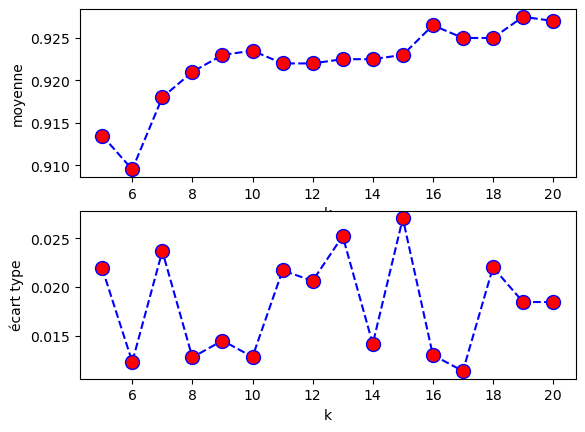

In [24]:
fig, ax = plt.subplots(2,1)

ax[0].plot(range(5,21),moyennes,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
ax[0].set_xlabel('k')
ax[0].set_ylabel('moyenne')
ax[1].plot(range(5,21),ecart_types,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
ax[1].set_xlabel('k')
ax[1].set_ylabel('écart type')
    

In [25]:
# on stocke les accuracies dans une liste :

accuracies2 = []
X2D_test = X2D[0:10]
Y2D_test = Y2D[0:10]

# seuil max des valeurs de k à regarder:
seuil_k = 1
# toutes les valeurs de k à regarder:
valeurs_k = [k for k in range(1,seuil_k,2)]

# ------------------------ A COMPLETER 

for i in valeurs_k:
    un_KNN3 = ClassifierKNN(2,i)
    un_KNN3.train(X2D,Y2D)
    accuracies2.append(un_KNN3.accuracy(X2D,Y2D))

# ---------------------------------------------
for i in range(0,len(valeurs_k)):
    print("Accuracy pour ",valeurs_k[i],":",accuracies2[i])


### Données 5D

In [26]:
#Parametres...à modifier
pourcentage_train = 0.7
k_max = 40  #max value de k à tester

In [27]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, y_train), (X_test, y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

In [28]:
#cellule lente
accuracies3 = []

for k in range(1,k_max+1):
    knn = ClassifierKNN(5,k)
    knn.train(X_train, y_train)
    acc = knn.accuracy(X_test, y_test)
    accuracies3.append(acc)
    

Text(0, 0.5, 'Accuracy')

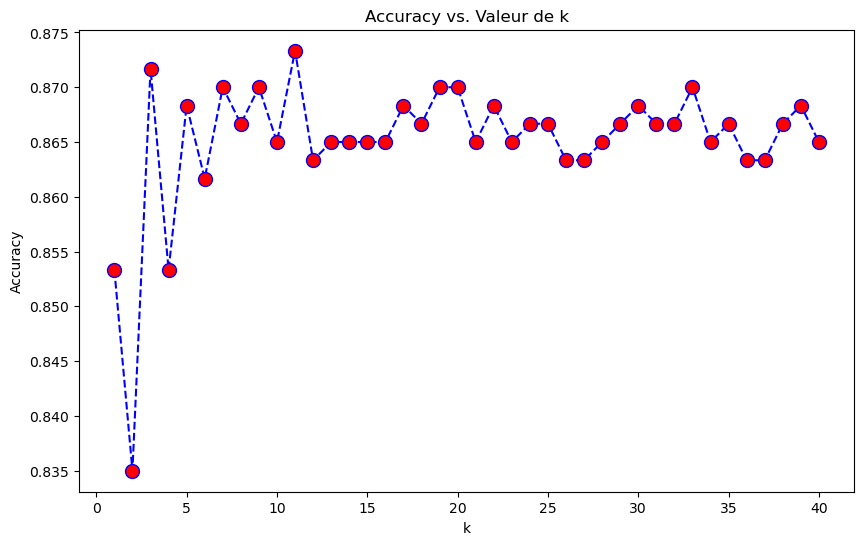

In [29]:
plt.figure(figsize=(10,6))
plt.plot(range(1,k_max+1),accuracies3,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Valeur de k')
plt.xlabel('k')
plt.ylabel('Accuracy')

In [30]:
plt.savefig('knn5Djusqua40.png')

<Figure size 640x480 with 0 Axes>

## Perceptron : 

### Données 2D 

In [31]:
npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

pourcentage_train = 0.7
npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


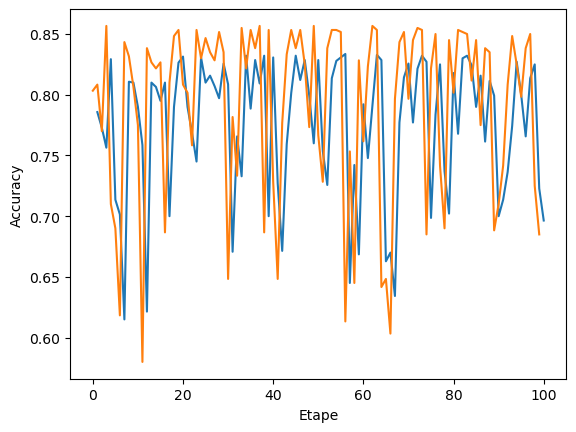

Accuracy finale (train):  0.6964285714285714
Accuracy finale (test) :  0.685


In [32]:
N=100

perceptron1 = ClassifierPerceptron(input_dimension = 2,learning_rate = 0.01,init = True)


train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


### Données 5D 

In [33]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

pourcentage_train = 0.7
npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

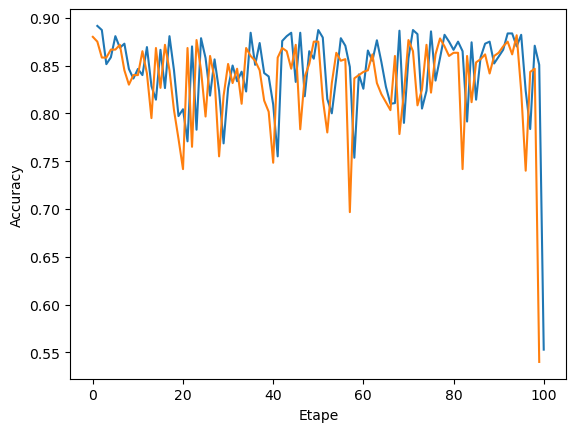

Accuracy finale (train):  0.5528571428571428
Accuracy finale (test) :  0.54


In [34]:
N=100

perceptron1 = ClassifierPerceptron(input_dimension = 5,learning_rate = 0.01,init = True)


train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


Perceptron biais :

In [35]:
#Code de génération du test-train split...pas à modifier
npos_total = Y2D[Y2D == +1].shape[0]
nneg_total = Y2D[Y2D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X2D, Y2D, npos_train, nneg_train)


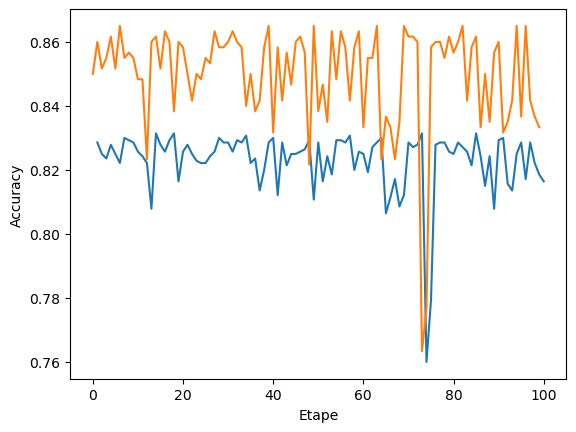

Accuracy finale (train):  0.8164285714285714
Accuracy finale (test) :  0.8333333333333334


In [36]:
N=100

perceptron1 = ClassifierPerceptronBiais(input_dimension=2, learning_rate=0.01, init=True)

train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])


In [37]:
#Code de génération du test-train split...pas à modifier
npos_total = Y5D[Y5D == +1].shape[0]
nneg_total = Y5D[Y5D == -1].shape[0]

npos_train = int(npos_total * pourcentage_train)
nneg_train = int(nneg_total * pourcentage_train)

(X_train, Y_train), (X_test, Y_test) = genere_train_test(X5D, Y5D, npos_train, nneg_train)

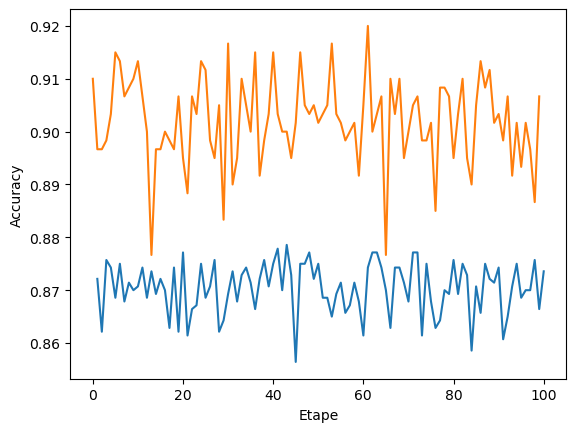

Accuracy finale (train):  0.8735714285714286
Accuracy finale (test) :  0.9066666666666666


In [38]:
N=100

perceptron1 = ClassifierPerceptronBiais(input_dimension=5, learning_rate=0.01, init=True)

train_acc = []
test_acc = []

for i in range(N):
    perceptron1.train(X_train, Y_train)
    train_acc.append(perceptron1.accuracy(X_train, Y_train))
    test_acc.append(perceptron1.accuracy(X_test,Y_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes (en prenant tous les exemples de la base)
#plot_frontiere(X2D,Y2D,perceptron1,step=150)
#plot2DSet(X2D,Y2D)

print("Accuracy finale (train): ",  train_acc[-1])
print("Accuracy finale (test) : ", test_acc[-1])

In [51]:
X_train.shape
#allw = np.array(perceptron1.get_allw()) 
#allw.shape
#X_train.shape
Y_train.shape


(1400,)

In [55]:

# on considère les poids de perceptron_biais généré dans une boite précédente:
allw = np.array(perceptron1.get_allw()) 



def couts(allw,X,Y):
    cout_liste = []
    for w in allw:
        cout = 0
        for xi,yi in zip(X,Y):    
            a = 1-np.dot(xi, w)*yi
            if (a > 0): 
                cout+=a
        cout_liste.append(cout)
    return cout_liste


def couts_vect(allw,X,Y):
    cout_liste = []
    for w in allw:
        alphas = np.ones(X.shape[0])
        alphas -= np.multiply(  np.matmul(X, np.transpose(w)) , Y)
        cout_liste.append(sum(alphas[alphas > 0]))
    return cout_liste


cout_liste = couts_vect(allw,X_train,Y_train)

print(cout_liste)
#plt.figure()
#plt.plot(cout_liste) # première coordonnée du vecteur poids: w1
#plt.title('Evolution de la fonction cout')
#plt.xlabel('iterations')
#plt.legend(['C'])